# Introduction

**Table of Contents:**

1. [Introduction](#Introduction)
2. [Load Modules and Libraries](#Load-Modules-and-Libraries)
3. [Load and Prepare Dataset](#Load-and-Prepare-Dataset)
4. [Preprocessing](#Preprocessing)
5. [Train Test Split](#Train-Test-Split)
6. [Traditional Machine Learning: Feature Engineering, Training, and Testing](#Traditional-Machine-Learning:-Feature-Engineering,-Training,-and-Testing)
7. [Deep Learning with LSTM: Feature Engineering, Training, and Testing](#Deep-Learning-with-LSTM:-Feature-Engineering,-Training,-and-Testing)
8. [Demonstration](#Demonstration)
9. [Conclusion](#Conclusion)

# Load Modules and Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
import subprocess
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import namedtuple
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.sequence import pad_sequences

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!


# Load and Prepare Dataset

In [ ]:
path = "/content/train.csv"
df = pd.read_csv(path)
df.head()
print(df.head)

NameError: name 'pd' is not defined

There is a column called "class" but it's not clear what it represents.

Let's see what "class" represents.

In [ ]:
(df
     .groupby("class")
     .agg(
        hate_speech_count=("hate_speech_count", "mean"),
        offensive_language_count=("offensive_language_count", "mean"),
        neither_count=("neither_count", "mean"),
     )
     .round(1)
)

,hate_speech_count,offensive_language_count,neither_count
class,,,
0,2.3,0.8,0.1
1,0.2,3.0,0.1
2,0.1,0.3,2.8


From this, we can see that
- class 0 = hate tweet
- class 1 = offensive tweet
- class 2 = neutral tweet

Let's remove unnecessary columns.

In [ ]:
df = (df
    .drop(columns=["count", "hate_speech_count", "offensive_language_count", "neither_count"])
)
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


Let's see the distribution of the labels.

In [ ]:
df["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.057701
1    0.774321
2    0.167978
Name: proportion, dtype: float64

Because class 0 is very few, I will merge class 0 with class 1 to make it hate speech+offensive language. Then, I will remap the class so that 0 = neutral and 1 = hate speech + offensive language.

In [ ]:
df = (df
    .assign(
        class_=df["class"].map({
            0:1,
            1:1,
            2:0
        })
    )
    .drop(columns=["class"])
    .rename(columns={"class_": "class"})
)

df["class"].value_counts(dropna=False, normalize=True).sort_index()

class
0    0.167978
1    0.832022
Name: proportion, dtype: float64

Now it becomes
- class 0 = neutral tweet
- class 1 = offensive tweet and hate speech tweet

In [ ]:
class_map = {
    0: "neutral",
    1: "offensive and hate speech"
}

# Text Cleaning

Now we need to clean our text because they are in raw tweet format; there is a lot of unnecessary elements like urls or twitter handles.

In [ ]:
def remove_urls(text, replacement_text=""):
    """Remove URLs from string."""
    pattern = re.compile(r"https?://\S+|www\.\S+")
    return pattern.sub(replacement_text, text)


def remove_twitter_handles(text, replacement_text=""):
    """Remove twitter handles from string."""
    pattern = re.compile(r"@[\w]+")
    return pattern.sub(replacement_text, text)


def remove_twitter_rt(text, replacement_text=""):
    """Remove twitter RTs from string."""
    pattern = re.compile(r"^RT|\s+RT\s+")
    return pattern.sub(replacement_text, text)


def remove_alphanumerics(text, replacement_text=" "):
    """Remove alphanumerics from string but leave single quote be."""
    pattern = re.compile(r"[^A-Za-z0-9']+")
    return pattern.sub(replacement_text, text)


def remove_multiple_whitespaces(text, replacement_text=" "):
    """Remove multiple whitespaces from string."""
    pattern = re.compile(r"\s{2,}")
    return pattern.sub(replacement_text, text)


def decode_html_character_references(text):
    """Decode HTML chacarters in string, e.g. &#38; and &amp;."""
    import html
    return html.unescape(text)


df = (df
    .assign(
        tweet_clean=lambda df_: (df_["tweet"]
            .apply(decode_html_character_references)
            .apply(remove_twitter_handles)
            .apply(remove_twitter_rt)
            .apply(remove_urls)
            .apply(remove_alphanumerics)
            .apply(remove_multiple_whitespaces)
            .str.strip()
        )
    )
)

df.tail()

,tweet,class,tweet_clean
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1,you's a muthaf in lie right His TL is trash No...
24779,"you've gone and broke the wrong heart baby, an...",0,you've gone and broke the wrong heart baby and...
24780,young buck wanna eat!!.. dat nigguh like I ain...,1,young buck wanna eat dat nigguh like I aint fu...
24781,youu got wild bitches tellin you lies,1,youu got wild bitches tellin you lies
24782,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...,0,Ruffled Ntac Eileen Dahlia Beautiful color com...


# Preprocessing

In [ ]:
def tokenize(doc):
    return word_tokenize(doc)


def remove_stopwords(doc):
    stops = set(stopwords.words("english"))
    stops.add("rt")
    return [token for token in doc if token not in stops]


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"ain\'t", "are not", phrase)
    phrase = re.sub(r"shan\'t", "shall not", phrase)
    phrase = re.sub(r"ma\'am", "maam", phrase)
    phrase = re.sub(r"y\'all", "you all", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

lemmatizer = WordNetLemmatizer()

df = (df
    .assign(
        tweet_preprocessed=lambda df_: (
            df_["tweet_clean"]
            .str.lower()
            .apply(lambda doc: [decontracted(word) for word in doc.split(" ")])
            .apply(lambda doc: [lemmatizer.lemmatize(word) for word in doc])
            .apply(lambda doc: " ".join(doc))
            .apply(word_tokenize)
            .apply(remove_stopwords)
       )
    )
)

df.sample(5)

,tweet,class,tweet_clean,tweet_preprocessed
7940,"Bands will make her dance , stamps will make h...",1,Bands will make her dance stamps will make her...,"[band, make, dance, stamp, make, twerk, romney..."
23976,i get what that girls point seems to be but co...,0,i get what that girls point seems to be but co...,"[get, girl, point, seems, colored, people, die..."
20905,Smile at the bitches who hate you.,1,Smile at the bitches who hate you,"[smile, bitch, hate]"
22506,We are back bitches! @vnpacheco21 @xoxoclaire_...,1,We are back bitches,"[back, bitch]"
31,""" i'd say im back to the old me but my old bit...",1,i'd say im back to the old me but my old bitch...,"[would, say, im, back, old, old, bitch, would,..."


# Train Test Split

In [ ]:
y = df["class"].values
x = df["tweet_preprocessed"].values
x = [(" ").join(doc) for  doc in x]

x = np.asarray(x)
y = np.asarray(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.1, random_state=8)

print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

22304 22304
2479 2479


# Traditional Machine Learning: Feature Engineering, Training, and Testing

In [ ]:
def return_score(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=0.0)
    recall = recall_score(y_true, y_pred, average="weighted")
    matrix = confusion_matrix(y_true, y_pred, normalize="true")
    Scores = namedtuple("Scores", ["acc", "f1", "precision", "recall", "matrix"])
    return Scores(acc, f1, precision, recall, matrix)

We will iterate through the defined models with StrafitiedKFold to check what are the best performing algorithm.

In [ ]:
dummy = DummyClassifier()
logistic = LogisticRegression(max_iter=1_000, random_state=8)
svc = LinearSVC(max_iter=1_000, random_state=8)
sgd = SGDClassifier()
knn = KNeighborsClassifier()
bayes = MultinomialNB()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
xgb = XGBClassifier()


models = [
    dummy,
    logistic,
    sgd,
    dt,
    rf,
    xgb,
]

for model in models:
    model_name = model.__class__.__name__
    model_scores = []

    print(model_name)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=8)
    for i, (train_index, val_index) in enumerate(skf.split(x_train, y_train)):

        print(f"\tFold {i}")

        # create train and val subset
        x_train_count = x_train[train_index]
        y_train_count = y_train[train_index]
        x_val_count = x_train[val_index]
        y_val_count = y_train[val_index]

        # oversample minority class in train set to deal with class imbalance
        # not oversample the val set to keep it untouched
        ros = RandomOverSampler(random_state=42)
        x_train_count, y_train_count = ros.fit_resample(x_train_count.reshape(-1, 1), y_train_count)
        x_train_count = x_train_count.flatten()

        if model_name != "DummyClassifier":
            # vectorize
            vectorizer = CountVectorizer()
            vectorizer.fit(x_train_count)
            x_train_count = vectorizer.transform(x_train_count)
            x_val_count = vectorizer.transform(x_val_count)

        # fit and predict
        model.fit(x_train_count, y_train_count)
        y_pred = model.predict(x_val_count)
        scores_this_fold = return_score(y_val_count, y_pred)
        model_scores.append(scores_this_fold)

    # print scores
    mean_acc = np.asarray([score.acc for score in model_scores]).mean()
    mean_f1 = np.asarray([score.f1 for score in model_scores]).mean()
    mean_precision = np.asarray([score.precision for score in model_scores]).mean()
    mean_recall = np.asarray([score.recall for score in model_scores]).mean()
    print(f"\tAcc: {mean_acc: .5f} | F1: {mean_f1: .5f} | Precision : {mean_precision: .5f} | Recall: {mean_recall: .5f}")

DummyClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.16800 | F1:  0.04833 | Precision :  0.02822 | Recall:  0.16800
LogisticRegression
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94871 | F1:  0.95039 | Precision :  0.95474 | Recall:  0.94871
SGDClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.95122 | F1:  0.95236 | Precision :  0.95482 | Recall:  0.95122
DecisionTreeClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94431 | F1:  0.94497 | Precision :  0.94596 | Recall:  0.94431
RandomForestClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94934 | F1:  0.94992 | Precision :  0.95082 | Recall:  0.94934
XGBClassifier
	Fold 0
	Fold 1
	Fold 2
	Fold 3
	Acc:  0.94790 | F1:  0.94999 | Precision :  0.95622 | Recall:  0.94790


As expected, XGBoost is our best model. Time to test out best model.

In [ ]:
xgb = XGBClassifier()
vectorizer = CountVectorizer()
ros = RandomOverSampler(random_state=42)

# resample
x_train_res, y_train_res = ros.fit_resample(x_train.reshape(-1, 1), y_train)
x_train_res = x_train_res.flatten()

# vectorize
vectorizer.fit(x_train_res)
x_train_vectorized = vectorizer.transform(x_train_res)
x_test_vectorized = vectorizer.transform(x_test)

# fit and predict
xgb.fit(x_train_vectorized, y_train_res)
y_pred = xgb.predict(x_test_vectorized)
scores = return_score(y_test, y_pred)

print(f"Acc: {scores.acc: .5f} | F1: {scores.f1: .5f} | Precision : {scores.precision: .5f} | Recall: {scores.recall: .5f}")

Acc:  0.94917 | F1:  0.95127 | Precision :  0.95774 | Recall:  0.94917


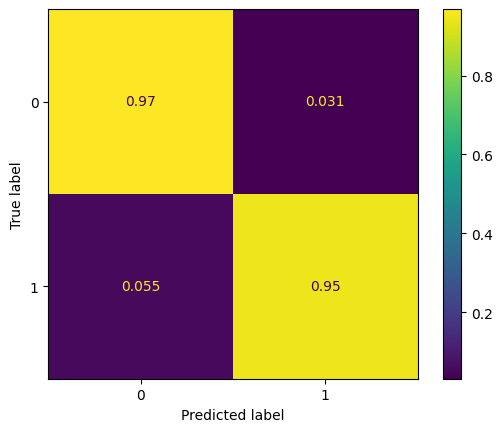

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize="true")
plt.show()

# Deep Learning with LSTM: Feature Engineering, Training, and Testing

Now we will see if we can achieve better result using LSTM.

Split out train and val first because previously we do not have it.

In [ ]:
x_train_nn, x_val_nn, y_train_nn, y_val_nn = train_test_split(
    x_train, y_train, test_size=0.1, stratify=y_train, random_state=8
)
x_test_nn = x_test.copy()
y_test_nn = y_test.copy()

print(x_train_nn.shape, y_train_nn.shape)
print(x_val_nn.shape, y_val_nn.shape)
print(x_test_nn.shape, y_test_nn.shape)

(20073,) (20073,)
(2231,) (2231,)
(2479,) (2479,)


Build word index.

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train_nn)

word_index = tokenizer.word_index
vocab_size = len(word_index)
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 16765


Then, map each word to their respective word index.

In [ ]:
x_train_nn = tokenizer.texts_to_sequences(x_train_nn)
x_val_nn = tokenizer.texts_to_sequences(x_val_nn)
x_test_nn = tokenizer.texts_to_sequences(x_test_nn)

In [ ]:
print(x_train_nn[:3])

[[1538, 1538, 107, 5, 198, 66, 849, 4, 207, 5, 164, 124, 4148], [249, 7592, 24], [16, 3440, 244, 1, 685, 3440]]


Now, our docs in corpus have variative length.

In [ ]:
min(len(doc) for doc in x_train_nn), max(len(doc) for doc in x_train_nn)

(0, 27)

We will pad them so they become of the same length.

In [ ]:
max_seq_length = 30
x_train_nn = pad_sequences(
    x_train_nn, maxlen=max_seq_length, padding="post", truncating="post"
)
x_val_nn = pad_sequences(
    x_val_nn, maxlen=max_seq_length, padding="post", truncating="post"
)
x_test_nn = pad_sequences(
    x_test_nn, maxlen=max_seq_length, padding="post", truncating="post"
)

min(len(doc) for doc in x_train_nn), max(len(doc) for doc in x_train_nn)

(30, 30)

Next, encode the target into categorical.

In [ ]:
from tensorflow.keras.utils import to_categorical

print(f"Before: {y_train_nn[:5]}")

y_train_nn = to_categorical(y_train_nn)
y_val_nn = to_categorical(y_val_nn)
y_test_nn = to_categorical(y_test_nn)

print(f"After: {y_train_nn[:5]}")

Before: [1 0 1 0 1]
After: [[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 64))
model.add(Bidirectional(LSTM(32, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(16, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(
    loss="categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.0001),
    metrics=["acc"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          1072960   
                                                                 
 bidirectional (Bidirection  (None, 64)                24832     
 al)                                                             
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1098866 (4.19 MB)
Trainable params: 1098866 (4.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/50
157/157 [==============================] - 48s 260ms/step - loss: 0.5810 - acc: 0.8291 - val_loss: 0.4651 - val_acc: 0.8319
Epoch 2/50
157/157 [==============================] - 35s 223ms/step - loss: 0.4463 - acc: 0.8320 - val_loss: 0.4448 - val_acc: 0.8319
Epoch 3/50
157/157 [==============================] - 32s 204ms/step - loss: 0.4365 - acc: 0.8320 - val_loss: 0.4350 - val_acc: 0.8319
Epoch 4/50
157/157 [==============================] - 33s 212ms/step - loss: 0.4217 - acc: 0.8320 - val_loss: 0.4158 - val_acc: 0.8319
Epoch 5/50
157/157 [==============================] - 31s 200ms/step - loss: 0.3838 - acc: 0.8320 - val_loss: 0.3373 - val_acc: 0.8324
Epoch 6/50
157/157 [==============================] - 31s 197ms/step - loss: 0.2282 - acc: 0.8953 - val_loss: 0.1827 - val_acc: 0.9189
Epoch 7/50
157/157 [==============================] - 32s 200ms/step - loss: 0.1639 - acc: 0.9332 - val_loss: 0.1649 - val_acc: 0.9251
Epoch 8/50
157/157 [==============================] - 3

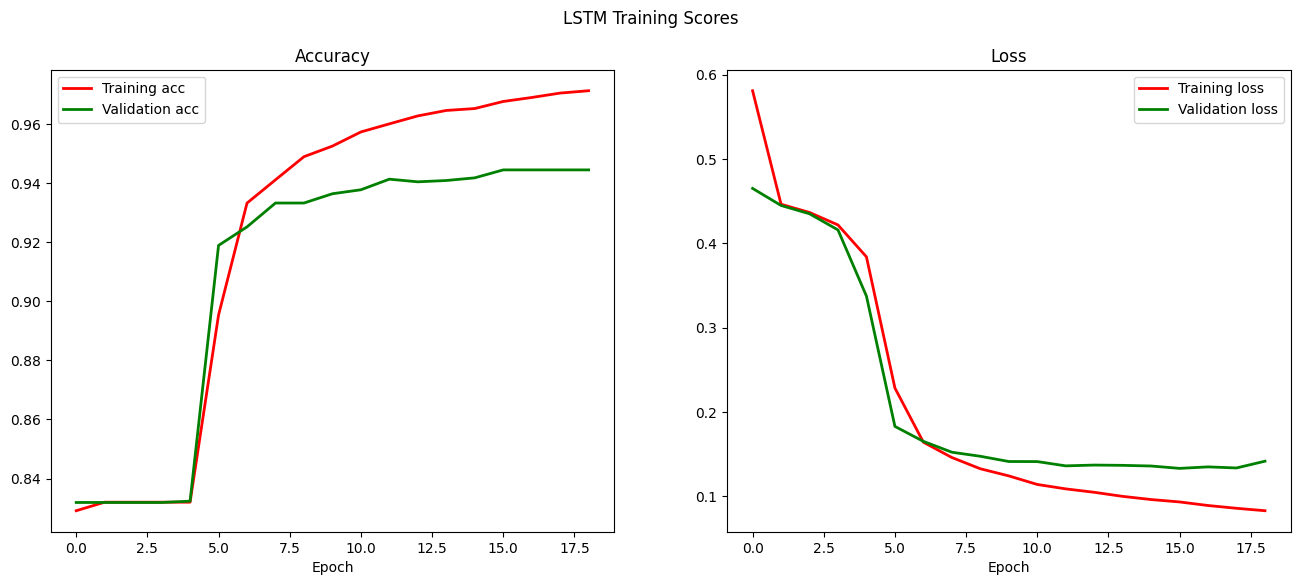

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    x_train_nn, y_train_nn,
    batch_size=128,
    epochs=50,
    validation_data=(x_val_nn, y_val_nn),
    callbacks=[early_stopping],
    verbose=1
)

hist = history.history

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.plot(hist['acc'],'r',linewidth=2, label='Training acc')
ax1.plot(hist['val_acc'], 'g',linewidth=2, label='Validation acc')
ax2.plot(hist['loss'],'r',linewidth=2, label='Training loss')
ax2.plot(hist['val_loss'], 'g',linewidth=2, label='Validation loss')

fig.suptitle('LSTM Training Scores')

ax1.set_title('Accuracy')
ax2.set_title('Loss')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')

ax1.legend()
ax2.legend()

plt.show()

Now test the model.

In [ ]:
y_pred = model.predict(x_test_nn)

scores = return_score(
    np.argmax(y_test_nn, axis=1), np.argmax(y_pred, axis=1)
)
print(f"Acc: {scores.acc: .5f} | F1: {scores.f1: .5f} | Precision : {scores.precision: .5f} | Recall: {scores.recall: .5f}")

78/78 [==============================] - 4s 46ms/step
Acc:  0.95119 | F1:  0.95209 | Precision :  0.95379 | Recall:  0.95119


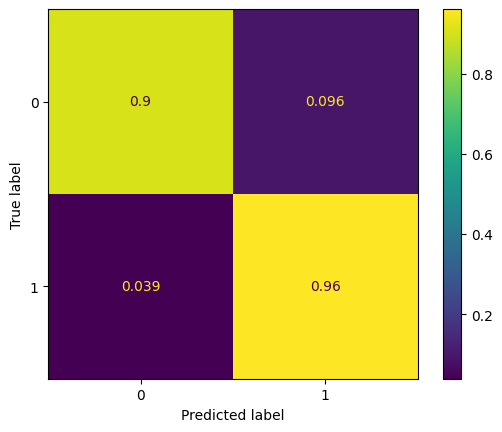

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_predictions(np.argmax(y_test_nn, axis=1), np.argmax(y_pred, axis=1), normalize="true")
plt.show()

# Demonstration

In [ ]:
# raw
# I apologize for the offensive language
test1 = "@IIITN I am relaxing at home."
test2 = "The bloody modi govt is running a fucking extortion racket."
test3 = "Recently Watched the @Shah_Rukh_Khan movie. Did not like it."
test4 = "I can't stand those immigrants ruining our country fuck them!!!"
test5 = "@melanie You damn broke bitch you should die LOL"
test6 = "@DeepPanchani I hate people like you"
test7 = "@DeepPanchani I love people like you"

docs = [test1, test2, test3, test4, test5, test6, test7]
# tokenize
docs_processed = tokenizer.texts_to_sequences(docs)
# pad
docs_processed = pad_sequences(docs_processed, maxlen=max_seq_length, padding="post", truncating="post")
# predict
y_pred = np.argmax(model.predict(docs_processed), axis=1)

print("\nHate speech and offensive language detention algorithm.")
print("\nI aplogize for the offensice language.")
print("\nModel prediction:")
for doc, label in zip(docs, y_pred):
    print(f"{doc: <75} : predicted as {class_map.get(label)}")

1/1 [==============================] - 0s 53ms/step

Hate speech and offensive language detention algorithm.

I aplogize for the offensice language.

Model prediction:
@IIITN I am relaxing at home.                                               : predicted as neutral
The bloody modi govt is running a fucking extortion racket.                 : predicted as offensive and hate speech
Recently Watched the @Shah_Rukh_Khan movie. Did not like it.                : predicted as neutral
I can't stand those immigrants ruining our country fuck them!!!             : predicted as offensive and hate speech
@melanie You damn broke bitch you should die LOL                            : predicted as offensive and hate speech
@DeepPanchani I hate people like you                                        : predicted as offensive and hate speech
@DeepPanchani I love people like you                                        : predicted as neutral


# Conclusion

In this notebook, we've looked into finding hateful and offensive language in Twitter posts. We used both basic machine learning and advanced deep learning techniques with LSTM networks. We started by setting up a simple model using a dummy classifier and then moved on to more complicated methods.

From our tests, we noticed that basic machine learning models sometimes struggle to understand the complicated language used in hate speech. But when we introduced LSTM networks, we saw a big improvement in how well the model worked. This shows that deep learning can be really effective in this area.

This is the conclusion for the Internship Project.